In [2]:
import numpy as np
import matplotlib.pyplot as plt

tensor(1.)


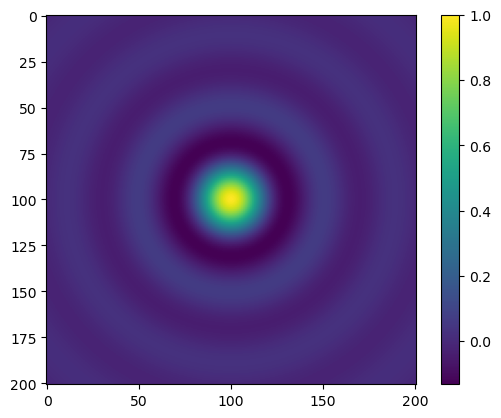

In [3]:
import torch
from torch.special import bessel_j1

wavelength = 632
fov = 5000
n_pix_psf = 201
na = 1
refractive_index = 1.5

airy_fun = lambda x: torch.where(x > 1e-6, 
                                 2 * bessel_j1(x) / x, 
                                 1 - x ** 2 / 8)
x = torch.linspace(-fov/2, fov/2, n_pix_psf)
xx, yy = torch.meshgrid(x, x, indexing='ij')
rr = torch.sqrt(xx ** 2 + yy ** 2)
k = 2 * np.pi / wavelength
limit = airy_fun(k * rr * na / refractive_index)
print(torch.max(torch.abs(limit)))

plt.imshow(limit)
plt.colorbar()
plt.show()

tensor(0.1814)


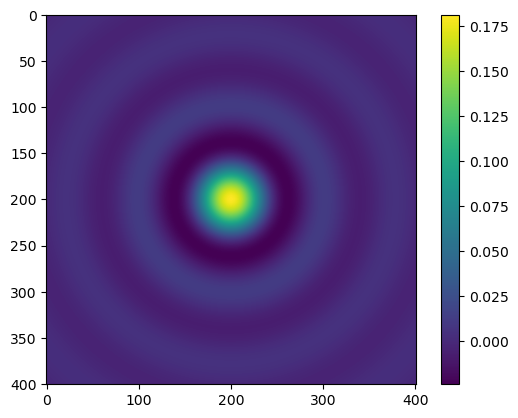

In [25]:
import os, sys
module_path = os.path.abspath(os.path.join('..')) + '/src/'
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from propagator import ScalarCartesianPropagator, ScalarPolarPropagator
from pupil import ScalarCartesianPupil, ScalarPolarPupil

n_pix_psf = 401
defocus = 0
n_defocus = 1
n_pix_pupil = 401
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
pupil1 = ScalarCartesianPupil(n_pix_pupil, device=device)
propagator1 = ScalarCartesianPropagator(pupil1, n_pix_psf=n_pix_psf, wavelength=wavelength, na=na, fov=fov,
                                        defocus_min=0, defocus_max=defocus, n_defocus=n_defocus, device=device,
                                        sz_correction=False, apod_factor=False)
field1 = propagator1.compute_focus_field()

print(torch.max(torch.abs(field1)))

plt.imshow(torch.imag(field1).squeeze())
plt.colorbar()
plt.show()

tensor(0.1814)


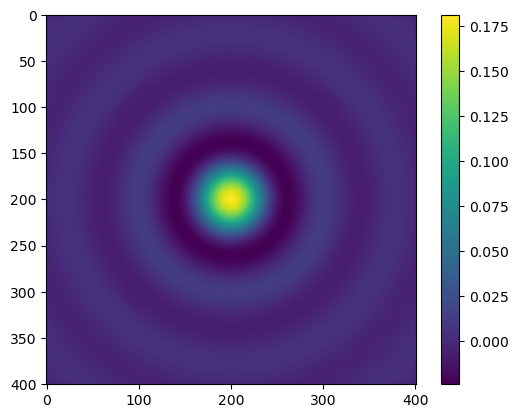

In [29]:
pupil2 = ScalarPolarPupil(n_pix_pupil, device=device)
propagator2 = ScalarPolarPropagator(pupil2, n_pix_psf=n_pix_psf, wavelength=wavelength, na=na, fov=fov,
                                        defocus_min=0, defocus_max=defocus, n_defocus=n_defocus, device=device,
                                        cos_factor=True, apod_factor=False)
field2 = propagator2.compute_focus_field()

print(torch.max(torch.abs(field2)))

plt.imshow(torch.real(field2).squeeze())
plt.colorbar()
plt.show()

In [45]:
k * na / refractive_index

0.006627832602510112

In [44]:
print(4*propagator1.s_max**2/2/np.pi/np.sqrt(refractive_index))

tensor(0.2310)


In [4]:
cartesian = np.load('benchmark_cartesian.npy')
polar = np.load('benchmark_polar.npy')
print(cartesian.shape)

(8,)


In [5]:
start_power = 3
n_points = 8
n_pix_pupils = np.logspace(start_power, start_power+n_points-1, n_points, base=2) + 1

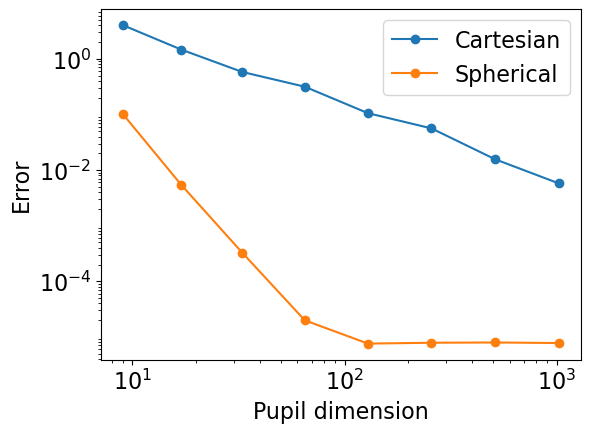

In [18]:
plt.loglog(n_pix_pupils, cartesian, label='Cartesian', marker='o')
plt.loglog(n_pix_pupils, polar, label='Spherical', marker='o')
plt.xlabel('Pupil dimension', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.yticks([1e-4, 1e-2, 1e0], fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=16)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)

plt.savefig('accuracy.svg', pad_inches=10)
plt.show()